# Gensim on Clinton Emails, and PCA
This Notebook attempts to use gensim to create Word2Vec Representations of a number of Clinton Emails and its words. Then, after running Gensim, it aims to reduce its dimensionality to 2, to see and analyze different clustering of similiarity of words in regards to their contextual usage

## Reading and Cleaning Data

First, importing the necessary packages/modules:

In [1]:
import pandas as pd
import gensim
import gensim.models
from gensim.models import Word2Vec
import re
import nltk.data
import matplotlib.pyplot as plt
%matplotlib inline
import string
from sklearn.decomposition import PCA


Reading Clinton Emails Data from Kaggle; we can see RawText column is where the textual data is at

In [2]:
data = pd.read_csv("../data/clinton/Emails.csv")
data.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [3]:
#Joining all the text in that column
rawtext = data["RawText"]
corpus = " ".join(rawtext)
corpus[:2000]

'UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739545\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN FULL\nFrom: Sullivan, Jacob J <Sullivan11@state.gov>\nSent: Wednesday, September 12, 2012 10:16 AM\nTo:\nSubject: FW: Wow\nFrom: Brose, Christian (Armed Services) (mailto:Christian_Brose@armed-servic,essenate.govi\nSent: Wednesday, September 12, 2012 10:09 AM\nTo: Sullivan, Jacob J\nSubject: Wow\nWhat a wonderful, strong and moving statement by your boss. please tell her how much Sen. McCain appreciated it. Me\ntoo\nUNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739545\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER. STATE-5CB0045247\n\x0c UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739546\n

## Cleaning Data

Removing stopwords and various clutter through regular expressions

In [4]:
#Preliminary Cleaning of special characters (not yet removing stopwords, remove after sentences are split)
clean_corp = (corpus.replace("\n", " ")).replace("\x0c", "")
clean_corp = re.sub('STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM. SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.', 
                    "", clean_corp)
clean_corp = re.sub('UNCLASSIFIED U.S. Department of State', "", clean_corp)

clean_corp[:2000]


' Case No. F-2015-04841 Doc No. C05739545 Date: 05/13/2015  RELEASE IN FULL From: Sullivan, Jacob J <Sullivan11@state.gov> Sent: Wednesday, September 12, 2012 10:16 AM To: Subject: FW: Wow From: Brose, Christian (Armed Services) (mailto:Christian_Brose@armed-servic,essenate.govi Sent: Wednesday, September 12, 2012 10:09 AM To: Sullivan, Jacob J Subject: Wow What a wonderful, strong and moving statement by your boss. please tell her how much Sen. McCain appreciated it. Me too  Case No. F-2015-04841 Doc No. C05739545 Date: 05/13/2015  STATE-5CB0045247   Case No. F-2015-04841 Doc No. C05739546 Date: 05/13/2015  RELEASE IN PART B6 From: Sent: To: Subject: Attachments: B6 Thursday, March 3, 2011 9:45 PM H: Latest How Syria is aiding Qaddafi and more... Sid hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx CONFIDENTIAL March 3, 2011 For: Hillary From: Sid Re: Syria aiding Qaddafi This memo has two parts. Part one is the report that Syria is providing air suppor

## Some Descriptive Statistics about the Dataset

In [5]:
#Number of Sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = tokenizer.tokenize(clean_corp)
len(sentences)

162853

In [6]:
#Number of Words (before removing stopwords)
split_sent = [re.split('\s+', sent) for sent in sentences]
bef_num_words = [len(sent) for sent in split_sent]
sum(bef_num_words)

2850367

In [7]:
#Removing stopwords, punctuation, Stemming text, and splitting stemmed words by spaces to create number of words
#per sentence
split_sentences = [gensim.parsing.preprocessing.remove_stopwords(sent) for sent in sentences]
split_sentences = [re.sub(r'[^\w\s]','',s) for s in split_sentences]
split_sentences = [gensim.parsing.preprocessing.stem_text(sent) for sent in split_sentences]
split_sentences = [re.split('\s+', sent) for sent in split_sentences]
split_sentences[0:5]

[['case', 'no'],
 ['f201504841', 'doc', 'no'],
 ['c05739545',
  'date',
  '05132015',
  'releas',
  'in',
  'full',
  'from',
  'sullivan',
  'jacob',
  'j',
  'sullivan11stategov',
  'sent',
  'wednesdai',
  'septemb',
  '12',
  '2012',
  '1016',
  'am',
  'to',
  'subject',
  'fw',
  'wow',
  'from',
  'brose',
  'christian',
  'arm',
  'servic',
  'mailtochristian_brosearmedservicessenategovi',
  'sent',
  'wednesdai',
  'septemb',
  '12',
  '2012',
  '1009',
  'am',
  'to',
  'sullivan',
  'jacob',
  'j',
  'subject',
  'wow',
  'what',
  'wonder',
  'strong',
  'move',
  'statement',
  'boss'],
 ['tell', 'sen', 'mccain', 'appreci', 'it'],
 ['me', 'case', 'no']]

In [8]:
#Number of words to be put into Word2Vec (so after removing stopwords & stemming)
aft_num_words = [len(sent) for sent in split_sentences]
sum(aft_num_words)

1911912

## Running the Model

In [9]:
#sg = 1 skipgram = T basically
#size = 50
#windows = 4
model = Word2Vec(split_sentences, min_count = 5, size= 100, window = 4, sg = 1)


In [10]:
#Number of embedded words (unique)
vocab = list(model.vocab.keys()) #All the unique vocabularies
len(vocab)

16129

In [11]:
#Skip-gram Output
non_reduced = [model[voc] for voc in vocab] #The Word2Vec representation after running skip-gram (output)
non_reduced[0:5]


[array([ -4.35153488e-03,  -1.48640727e-04,   2.69790343e-03,
          2.38216901e-03,  -1.87105767e-03,  -5.55783045e-04,
          3.96852382e-03,  -4.27124137e-03,   2.75490782e-03,
         -1.66829734e-03,  -8.60037457e-04,   3.25840665e-03,
         -3.92237864e-03,   4.52659512e-03,   2.08358560e-03,
         -4.71105892e-03,   6.00425003e-04,  -8.95293080e-04,
          4.02422016e-03,  -1.59751880e-03,  -9.68050270e-04,
         -1.83085853e-03,  -2.72934674e-03,   6.72419614e-04,
         -7.67186109e-04,   4.19479702e-03,   7.66559271e-04,
          4.92259255e-03,   1.23242917e-03,  -4.14540106e-03,
          3.49235209e-03,   9.56986740e-04,   3.00518889e-03,
         -4.44373727e-04,  -1.22517021e-03,   4.38700983e-04,
         -4.42031166e-03,   4.30694036e-03,   5.87967748e-04,
         -1.05248590e-03,   3.62073840e-03,  -5.18041488e-05,
          3.33598495e-04,   3.63486283e-03,   3.67365102e-03,
         -4.61047702e-03,   4.42181155e-03,   2.49187869e-04,
        

## Principal Component Analysis and Dimensionality Reduction

In [12]:
#PCA Model, reducing dimensionality to 2 dimensions
pca = PCA(n_components = 2)
words_reduced = pca.fit(non_reduced).transform(non_reduced)
words_reduced[0:5]

array([[-0.08291687,  0.39989504],
       [ 0.15361879,  0.33754895],
       [-0.94314385, -0.17109944],
       [ 1.95748972, -0.57490849],
       [ 0.00902071,  0.01970725]])

In [13]:
#Getting X and Y values to plot
x_val = [x[0] for x in words_reduced]
y_val = [y[0] for y in words_reduced]

In [14]:
import random
words = random.sample(vocab, 10)
random.sample(vocab, 100)

['mildli',
 'wyclef',
 'c05739627',
 'hello',
 'daylight',
 'plane',
 '9pm',
 'c05766135',
 'd',
 'comptrol',
 '6040',
 'chapel',
 '217',
 'twohour',
 'lgbt',
 '809',
 'don',
 'c05770489',
 'cabinet',
 'redlin',
 'secret',
 'antieurop',
 '2026476115',
 'yanke',
 'other',
 'fly',
 'topic',
 '184526',
 'must',
 'textplain',
 'persona',
 'dakota',
 'approxim',
 'pure',
 'marton',
 'spade',
 'engel',
 'fattal',
 'arctic',
 '425',
 'newswikileak',
 'northern',
 'storm',
 'rican',
 'ecstat',
 'pollard',
 '2026477209',
 'stf',
 'learn',
 'prosecutor',
 'hainan',
 'urban',
 'fob',
 'literari',
 'critic',
 'fixtur',
 'port',
 'receiv',
 'castrat',
 'c05760179',
 '32009',
 'weaker',
 'postconflict',
 'heck',
 'laila',
 'amar',
 'tirelessli',
 'ford',
 'hussein',
 'ryan',
 'cote',
 'vers',
 'coleman',
 'c05775475',
 'rather',
 'mislead',
 'unavoid',
 'demagog',
 'happen',
 'pardon',
 '28',
 'version',
 'alarusi',
 'calif',
 'horrif',
 'character',
 'sistanc',
 'subvert',
 'bolkstein',
 'oman',
 '

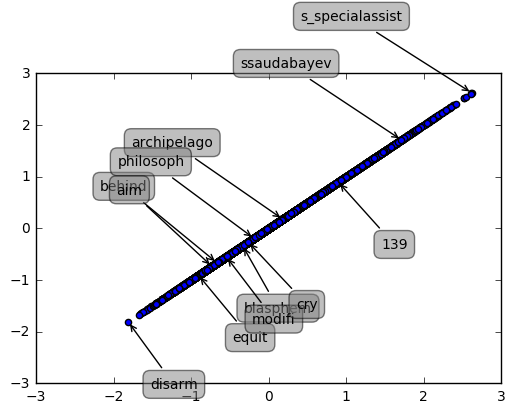

In [15]:
#Annotation and plotting figure on 2-d area with Labels

#Creating figure, and plotting scatter
fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)
plt.scatter(x_val, y_val)

#Handpicked words to see comparisons

#words = ['magic', 'japanes', 'transnat', 'lawsuit', 'scapegoat', 'sanction', 'coverup', 'lesbian']
    #un-comment if want hand-picked
words.append(vocab[x_val.index(min(x_val))])
words.append(vocab[x_val.index(max(x_val))]) #Appending max and min outliers

#Annotation
for i, word in enumerate(words):
    x = x_val[vocab.index(word)]
    y = y_val[vocab.index(word)]
    if i % 2 == 1:
        offset = (-50, 50)
    else:
        offset = (50, -50)
    plt.annotate(word, xy = (x, y), xytext = offset,
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'grey', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()